In [1]:
!git clone --depth 1 https://github.com/chulminkw/automl

Cloning into 'automl'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (143/143), done.
remote: Total 147 (delta 14), reused 19 (delta 0), pack-reused 0
Receiving objects: 100% (147/147), 9.62 MiB | 17.94 MiB/s, done.
Resolving deltas: 100% (14/14), done.


In [4]:
!cd /content/automl/efficientdet; pip install -r requirements.txt

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-lfvxu4nh
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-lfvxu4nh


In [3]:
import tensorflow as tf
print(tf.__version__)

2.6.0


In [4]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [5]:
import os
import sys
import tensorflow.compat.v1 as tf

In [6]:
sys.path.append('/content/automl/efficientdet')

In [6]:
import hparams_config
from _keras import anchors
from model_inspect import ModelInspector

ModuleNotFoundError: ignored

In [8]:
MODEL = 'efficientdet-d0' 

def download(m):
  if m not in os.listdir():
    !wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientdet/coco/{m}.tar.gz
    !tar zxf {m}.tar.gz
  ckpt_path = os.path.join(os.getcwd(), m)
  return ckpt_path

# Download checkpoint.
ckpt_path = download(MODEL)
print('Use model in {}'.format(ckpt_path))

--2021-10-01 05:54:19--  https://storage.googleapis.com/cloud-tpu-checkpoints/efficientdet/coco/efficientdet-d0.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.128, 142.251.2.128, 74.125.137.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28994253 (28M) [application/octet-stream]
Saving to: ‘efficientdet-d0.tar.gz’

efficientdet-d0.tar 100%[===================>]  27.65M  51.1MB/s    in 0.5s    

2021-10-01 05:54:20 (51.1 MB/s) - ‘efficientdet-d0.tar.gz’ saved [28994253/28994253]

Use model in /content/efficientdet-d0


In [9]:
!mkdir ./data
!wget -O ./data/img01.png https://user-images.githubusercontent.com/11736571/77320690-099af300-6d37-11ea-9d86-24f14dc2d540.png

--2021-10-01 05:54:33--  https://user-images.githubusercontent.com/11736571/77320690-099af300-6d37-11ea-9d86-24f14dc2d540.png
Resolving user-images.githubusercontent.com (user-images.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to user-images.githubusercontent.com (user-images.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4080549 (3.9M) [image/png]
Saving to: ‘./data/img01.png’

./data/img01.png    100%[===================>]   3.89M  --.-KB/s    in 0.05s   

2021-10-01 05:54:34 (73.3 MB/s) - ‘./data/img01.png’ saved [4080549/4080549]



(1080, 1920, 3)


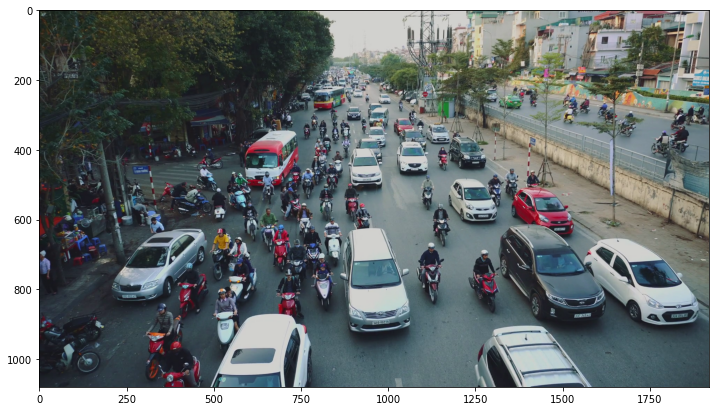

In [10]:
import cv2
import matplotlib.pyplot as plt

image_array = cv2.cvtColor(cv2.imread('/content/data/img01.png'), cv2.COLOR_BGR2RGB)
print(image_array.shape)

plt.figure(figsize=(12, 12))
plt.imshow(image_array)

In [11]:
class INFER_CFG:
  model_name = 'efficientdet-d0' # efficientdet 모델명
  model_dir = '/content/efficientdet-d0' # pretrained checkpoint 파일이 있는 디렉토리
  hparams = '' # csv 형식의 k=v 쌍 또는 yaml file

In [12]:
import numpy as np
from PIL import Image
import tensorflow as tf

import hparams_config
import inference
from _keras import efficientdet_keras

In [13]:
#efficientdet-d0의 기본 config 확인. 
config = hparams_config.get_efficientdet_config(INFER_CFG.model_name)
print(config)

act_type: swish
alpha: 0.25
anchor_scale: 4.0
apply_bn_for_resampling: true
aspect_ratios:
- 1.0
- 2.0
- 0.5
autoaugment_policy: null
backbone_config: null
backbone_name: efficientnet-b0
box_class_repeats: 3
box_loss_weight: 50.0
ckpt_var_scope: null
clip_gradients_norm: 10.0
conv_after_downsample: false
conv_bn_act_pattern: false
data_format: channels_last
dataset_type: null
delta: 0.1
drop_remainder: true
first_lr_drop_epoch: 200.0
fpn_cell_repeats: 3
fpn_config: null
fpn_name: null
fpn_num_filters: 64
fpn_weight_method: null
gamma: 1.5
grad_checkpoint: false
grid_mask: false
heads:
- object_detection
image_size: 512
img_summary_steps: null
input_rand_hflip: true
iou_loss_type: null
iou_loss_weight: 1.0
is_training_bn: true
jitter_max: 2.0
jitter_min: 0.1
label_map: null
label_smoothing: 0.0
learning_rate: 0.08
loss_scale: null
lr_decay_method: cosine
lr_warmup_epoch: 1.0
lr_warmup_init: 0.008
map_freq: 5
max_instances_per_image: 100
max_level: 7
mean_rgb:
- 123.675
- 116.28
- 103.53

In [14]:
config.is_training_bn = False
config.nms_configs.score_thresh = 0.4
config.nms_configs.max_output_size = 100

config.override(INFER_CFG.hparams)

In [15]:
import inference
from _keras import efficientdet_keras

model = efficientdet_keras.EfficientDetModel(config=config)
model.build((None, None, None, 3))
model.load_weights(tf.train.latest_checkpoint(INFER_CFG.model_dir))
model.summary()

/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py:1348: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


Instructions for updating:
Restoring a name-based tf.train.Saver checkpoint using the object-based restore API. This mode uses global names to match variables, and so is somewhat fragile. It also adds new restore ops to the graph each time it is called when graph building. Prefer re-encoding training checkpoints in the object-based format: run save() on the object-based saver (the same one this message is coming from) and use that checkpoint in the future.


Instructions for updating:
Restoring a name-based tf.train.Saver checkpoint using the object-based restore API. This mode uses global names to match variables, and so is somewhat fragile. It also adds new restore ops to the graph each time it is called when graph building. Prefer re-encoding training checkpoints in the object-based format: run save() on the object-based saver (the same one this message is coming from) and use that checkpoint in the future.


Model: ""
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      multiple                  3634844   
_________________________________________________________________
resample_p6 (ResampleFeature multiple                  20800     
_________________________________________________________________
resample_p7 (ResampleFeature multiple                  0         
_________________________________________________________________
fpn_cells (FPNCells)         multiple                  179321    
_________________________________________________________________
class_net (ClassNet)         multiple                  71274     
_________________________________________________________________
box_net (BoxNet)             multiple                  20964     
Total params: 3,927,203
Trainable params: 3,880,067
Non-trainable params: 47,136
___________________________________________________

In [16]:
from PIL import Image
import cv2

# image는 4차원 array, Tensor 모두 가능.  
imgs = [np.array(Image.open('/content/data/img01.png'))]
imgs = tf.convert_to_tensor(imgs, dtype=tf.uint8)

### 아래와 같이 numpy array도 모델에 입력되는 이미지 값으로 가능. 
''' 
img = cv2.cvtColor(cv2.imread('/content/data/img01.png'), cv2.COLOR_BGR2RGB)
imgs= img[np.newaxis, ...]
boxes, scores, classes, valid_len = model(imgs, training=False, post_mode='global')
'''
print()

In [21]:
import time

# Inference 수행하고 수행 시간을 측정. 
start_time = time.time()
boxes, scores, classes, valid_len = model(imgs, training=False, post_mode='global')
print('elapsed time:', time.time() - start_time)

/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py:1348: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


elapsed time: 0.707866907119751


In [22]:
boxes.shape, classes.shape, scores.shape

(TensorShape([1, 100, 4]), TensorShape([1, 100]), TensorShape([1, 100]))

In [23]:
valid_len.numpy()

array([13], dtype=int32)

In [24]:
!mkdir -p  /content/data_output

In [26]:
for i, img in enumerate(imgs):
    length = valid_len[i]
    img = inference.visualize_image(
        img,
        boxes[i].numpy()[:length],
        classes[i].numpy().astype(np.int)[:length],
        scores[i].numpy()[:length],
        label_map=config.label_map,
        min_score_thresh=config.nms_configs.score_thresh,
        max_boxes_to_draw=config.nms_configs.max_output_size)
    output_image_path = os.path.join('/content/data_output', str(i) + '.jpg')
    Image.fromarray(img).save(output_image_path)
    print('writing annotated image to %s' % output_image_path)

writing annotated image to /content/data_output/0.jpg


In [30]:
import time

class ExportModel(tf.Module):

    def __init__(self, model):
        super().__init__()
        self.model = model
    
    @tf.function
    def f(self, imgs):
        return self.model(imgs, training=False, post_mode='global')

export_model = ExportModel(model)

In [35]:
start_time = time.time()
boxes, scores, classes, valid_len = export_model.f(imgs)

print('elapsed time:', time.time() - start_time)

elapsed time: 0.31612205505371094


In [36]:
labels_to_names = {1:'person',2:'bicycle',3:'car',4:'motorcycle',5:'airplane',6:'bus',7:'train',8:'truck',9:'boat',10:'traffic light',
                    11:'fire hydrant',12:'street sign',13:'stop sign',14:'parking meter',15:'bench',16:'bird',17:'cat',18:'dog',19:'horse',20:'sheep',
                    21:'cow',22:'elephant',23:'bear',24:'zebra',25:'giraffe',26:'hat',27:'backpack',28:'umbrella',29:'shoe',30:'eye glasses',
                    31:'handbag',32:'tie',33:'suitcase',34:'frisbee',35:'skis',36:'snowboard',37:'sports ball',38:'kite',39:'baseball bat',40:'baseball glove',
                    41:'skateboard',42:'surfboard',43:'tennis racket',44:'bottle',45:'plate',46:'wine glass',47:'cup',48:'fork',49:'knife',50:'spoon',
                    51:'bowl',52:'banana',53:'apple',54:'sandwich',55:'orange',56:'broccoli',57:'carrot',58:'hot dog',59:'pizza',60:'donut',
                    61:'cake',62:'chair',63:'couch',64:'potted plant',65:'bed',66:'mirror',67:'dining table',68:'window',69:'desk',70:'toilet',
                    71:'door',72:'tv',73:'laptop',74:'mouse',75:'remote',76:'keyboard',77:'cell phone',78:'microwave',79:'oven',80:'toaster',
                    81:'sink',82:'refrigerator',83:'blender',84:'book',85:'clock',86:'vase',87:'scissors',88:'teddy bear',89:'hair drier',90:'toothbrush',
                    91:'hair brush'}

In [39]:
def get_detected_img(export_model, img_array, is_print=True):
    draw_img = img_array.copy()

    green_color = (0, 255 , 0)
    red_color = (0, 0, 255)

    img_tensor = tf.convert_to_tensor(img_array, dtype=tf.uint8)[tf.newaxis, ...]

    start_time = time.time()
    boxes, scores, classes, valid_len = export_model.f(img_tensor)
    boxes = boxes[0].numpy()
    scores = scores[0].numpy()
    classes = classes[0].numpy()
    valid_len = valid_len[0].numpy()

    for i in range(valid_len):
        score = scores[i]
        box = boxes[i]
        class_id = labels_to_names[classes[i]]

        left = int(box[1])
        top = int(box[0])
        right = int(box[3])
        bottom = int(box[2])

        caption = '{}:{:.4f}'.format(class_id, score)

        cv2.rectangle(draw_img, (left, top), (right, bottom), green_color, thickness = 2)
        cv2.putText(draw_img, caption, (left, top-5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, red_color, 1)

    if is_print:
        print('Detection 수행시간:', round(time.time() - start_time, 4))

    return draw_img

Detection 수행시간: 0.3509


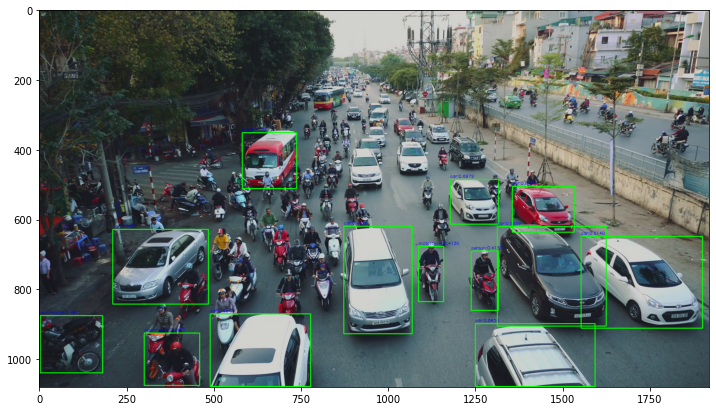

In [40]:
import cv2

img_array = cv2.imread('/content/data/img01.png')
img_rgb = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)

draw_img = get_detected_img(export_model, img_rgb, is_print=True)

plt.figure(figsize=(12,12))
plt.imshow(draw_img)
plt.show()

In [41]:
!wget -O ./data/beatles01.jpg https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/beatles01.jpg
!wget -O ./data/baseball01.jpg https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/baseball01.jpg

--2021-10-01 06:37:55--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/beatles01.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 383118 (374K) [image/jpeg]
Saving to: ‘./data/beatles01.jpg’

./data/beatles01.jp 100%[===================>] 374.14K  --.-KB/s    in 0.02s   

2021-10-01 06:37:55 (16.0 MB/s) - ‘./data/beatles01.jpg’ saved [383118/383118]

--2021-10-01 06:37:55--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/baseball01.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7627

(633, 806, 3)


/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py:1348: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


Detection 수행시간: 4.9554


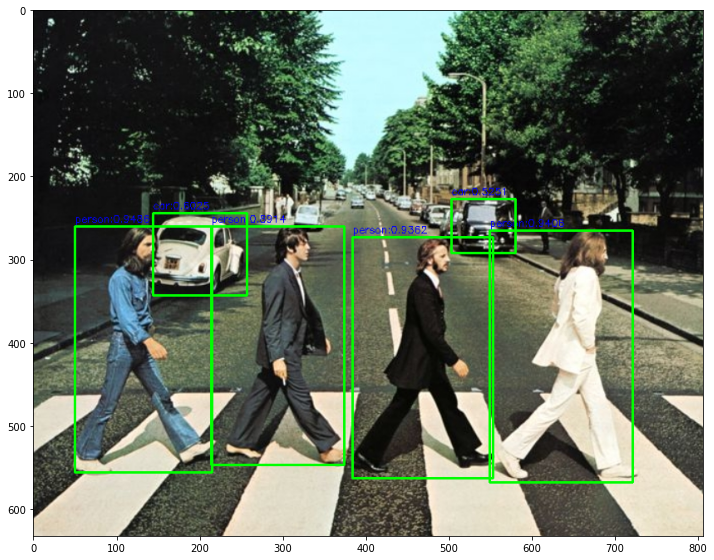

In [42]:
import cv2
img_array = cv2.cvtColor(cv2.imread('/content/data/beatles01.jpg'), cv2.COLOR_BGR2RGB)
print(img_array.shape)

draw_img = get_detected_img(export_model, img_array, is_print=True)
plt.figure(figsize=(12, 12))
plt.imshow(draw_img)

(476, 735, 3)


/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py:1348: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


Detection 수행시간: 5.1591


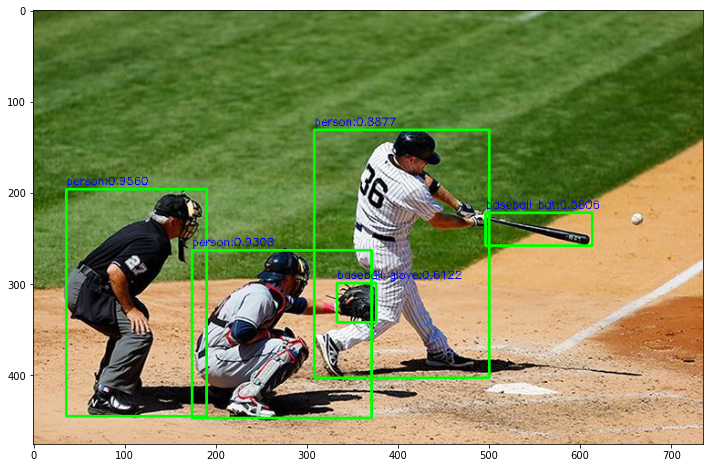

In [43]:
import cv2
img_array = cv2.cvtColor(cv2.imread('/content/data/baseball01.jpg'), cv2.COLOR_BGR2RGB)
print(img_array.shape)

draw_img = get_detected_img(export_model, img_array, is_print=True)
plt.figure(figsize=(12, 12))
plt.imshow(draw_img)

In [2]:
!pip install hparams_config

ERROR: Could not find a version that satisfies the requirement hparams_config (from versions: none)
ERROR: No matching distribution found for hparams_config


In [1]:
import os
import sys
import numpy as np
import tensorflow as tf

sys.path.append('/content/automl/efficientdet')

import hparams_config
from _keras import anchors
from model_inspect import ModelInspector

import inference
from _keras import efficientdet_keras

class INFER_CFG:
    model_name = 'efficientdet-d0'
    model_dir = '/content/efficientdet-d0'
    hparams = ''

config = hparams_config.get_efficientdet_config(INFER_CFG.model_name)
config.is_training_bn = False
config.image_size = '1920x1280'
config.nms_configs.score_thresh = 0.4
config.nms_configs.max_output_size = 100
config.override(INFER_CFG.hparams)

model = efficientdet_keras.EfficientDetModel(config=config)
model.build((None, None, None, 3))
model.load_weights(tf.train.latest_checkpoint(INFER_CFG.model_dir))
model.summary()

class ExportModel(tf.Module):

    def __init__(self, model):
        self.model = model

    @tf.function
    def f(self, imgs):
        return self.model(imgs, training=False, post_mode='global')

export_model = ExportModel(model)

/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py:1348: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


Instructions for updating:
Restoring a name-based tf.train.Saver checkpoint using the object-based restore API. This mode uses global names to match variables, and so is somewhat fragile. It also adds new restore ops to the graph each time it is called when graph building. Prefer re-encoding training checkpoints in the object-based format: run save() on the object-based saver (the same one this message is coming from) and use that checkpoint in the future.


Instructions for updating:
Restoring a name-based tf.train.Saver checkpoint using the object-based restore API. This mode uses global names to match variables, and so is somewhat fragile. It also adds new restore ops to the graph each time it is called when graph building. Prefer re-encoding training checkpoints in the object-based format: run save() on the object-based saver (the same one this message is coming from) and use that checkpoint in the future.


Model: ""
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      multiple                  3634844   
_________________________________________________________________
resample_p6 (ResampleFeature multiple                  20800     
_________________________________________________________________
resample_p7 (ResampleFeature multiple                  0         
_________________________________________________________________
fpn_cells (FPNCells)         multiple                  179321    
_________________________________________________________________
class_net (ClassNet)         multiple                  71274     
_________________________________________________________________
box_net (BoxNet)             multiple                  20964     
Total params: 3,927,203
Trainable params: 3,880,067
Non-trainable params: 47,136
___________________________________________________

In [2]:
# p100에서 image 1920x1280일 경우 74ms, image 512x512일 경우 27ms, v100에서 image 512x512일 경우 24ms
import time
import cv2 

img = cv2.cvtColor(cv2.imread('/content/data/img01.png'), cv2.COLOR_BGR2RGB)
imgs= img[np.newaxis, ...]

start_time = time.time()
boxes, scores, classes, valid_len = export_model.f(imgs)

print('elapsed time:', time.time() - start_time)

/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py:1348: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


elapsed time: 10.050574541091919


In [3]:
labels_to_names = {1:'person',2:'bicycle',3:'car',4:'motorcycle',5:'airplane',6:'bus',7:'train',8:'truck',9:'boat',10:'traffic light',
                    11:'fire hydrant',12:'street sign',13:'stop sign',14:'parking meter',15:'bench',16:'bird',17:'cat',18:'dog',19:'horse',20:'sheep',
                    21:'cow',22:'elephant',23:'bear',24:'zebra',25:'giraffe',26:'hat',27:'backpack',28:'umbrella',29:'shoe',30:'eye glasses',
                    31:'handbag',32:'tie',33:'suitcase',34:'frisbee',35:'skis',36:'snowboard',37:'sports ball',38:'kite',39:'baseball bat',40:'baseball glove',
                    41:'skateboard',42:'surfboard',43:'tennis racket',44:'bottle',45:'plate',46:'wine glass',47:'cup',48:'fork',49:'knife',50:'spoon',
                    51:'bowl',52:'banana',53:'apple',54:'sandwich',55:'orange',56:'broccoli',57:'carrot',58:'hot dog',59:'pizza',60:'donut',
                    61:'cake',62:'chair',63:'couch',64:'potted plant',65:'bed',66:'mirror',67:'dining table',68:'window',69:'desk',70:'toilet',
                    71:'door',72:'tv',73:'laptop',74:'mouse',75:'remote',76:'keyboard',77:'cell phone',78:'microwave',79:'oven',80:'toaster',
                    81:'sink',82:'refrigerator',83:'blender',84:'book',85:'clock',86:'vase',87:'scissors',88:'teddy bear',89:'hair drier',90:'toothbrush',
                    91:'hair brush'}

In [4]:
def get_detected_img(export_model, img_array, is_print=True):   
  # automl efficent은 반환 bbox 좌표값이 원본 이미지 좌표값으로 되어 있으므로 별도의 scaling작업 필요 없음. 
  '''
  height = img_array.shape[0]
  width = img_array.shape[1]
  '''
  # cv2의 rectangle()은 인자로 들어온 이미지 배열에 직접 사각형을 업데이트 하므로 그림 표현을 위한 별도의 이미지 배열 생성. 
  draw_img = img_array.copy()

  # bounding box의 테두리와 caption 글자색 지정
  green_color=(0, 255, 0)
  red_color=(0, 0, 255)

  # cv2로 만들어진 numpy image array를 tensor로 변환
  img_tensor = tf.convert_to_tensor(img_array, dtype=tf.uint8)[tf.newaxis, ...]
  #img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)[tf.newaxis, ...]

  # efficientdet 모델을 다운로드 한 뒤 inference 수행. 
  start_time = time.time()
  # automl efficientdet 모델은 boxes, score, classes, num_detections를 각각 Tensor로 반환. 
  boxes, scores, classes, valid_len = export_model.f(img_tensor)
  # Tensor값을 시각화를 위해 numpy 로 변환. 
  boxes = boxes.numpy()
  scores = scores.numpy()
  classes = classes.numpy()
  valid_len = valid_len.numpy()
  
  # detected 된 object들을 iteration 하면서 정보 추출. detect된 object의 갯수는 100개
  for i in range(valid_len[0]):
    # detection score를 iteration시 마다 높은 순으로 추출하고 SCORE_THRESHOLD보다 낮으면 loop 중단. 
    score = scores[0, i]
    
    # detected된 object들은 scale된 기준으로 예측되었으므로 다시 원본 이미지 비율로 계산
    box = boxes[0, i]

    ''' **** 주의 ******
    box는 ymin, xmin, ymax, xmax 순서로 되어 있음. 또한 원본 좌표값으로 되어 있음. '''
    left = box[1]
    top = box[0] 
    right = box[3] 
    bottom = box[2] 

    # class id 추출하고 class 명으로 매핑
    class_id = classes[0, i]
    caption = "{}: {:.4f}".format(labels_to_names[class_id], score)
    print(caption)
    #cv2.rectangle()은 인자로 들어온 draw_img에 사각형을 그림. 위치 인자는 반드시 정수형.
    cv2.rectangle(draw_img, (int(left), int(top)), (int(right), int(bottom)), color=green_color, thickness=2)
    cv2.putText(draw_img, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, red_color, 1)

  if is_print:
    print('Detection 수행시간:',round(time.time() - start_time, 2),"초")

  return draw_img

car: 0.9021
car: 0.8520
car: 0.8487
car: 0.8333
car: 0.8323
car: 0.8282
car: 0.8255
motorcycle: 0.8187
car: 0.8071
person: 0.7914
car: 0.7907
motorcycle: 0.7842
motorcycle: 0.7740
car: 0.7728
person: 0.7693
person: 0.7683
bus: 0.7670
person: 0.7566
person: 0.7547
person: 0.7471
person: 0.7445
car: 0.7234
person: 0.7191
motorcycle: 0.7107
person: 0.7092
person: 0.7058
person: 0.7020
person: 0.6910
car: 0.6864
motorcycle: 0.6836
person: 0.6831
person: 0.6802
motorcycle: 0.6747
person: 0.6733
bus: 0.6674
car: 0.6643
person: 0.6572
person: 0.6565
person: 0.6478
car: 0.6474
person: 0.6434
person: 0.6376
person: 0.6326
car: 0.6318
person: 0.6287
person: 0.6285
person: 0.6233
person: 0.6183
car: 0.6170
car: 0.6085
person: 0.6049
person: 0.6043
car: 0.6012
person: 0.5999
person: 0.5903
car: 0.5813
person: 0.5772
motorcycle: 0.5733
person: 0.5705
person: 0.5557
motorcycle: 0.5504
person: 0.5492
person: 0.5386
person: 0.5355
person: 0.5347
person: 0.5345
motorcycle: 0.5325
motorcycle: 0.5286
per

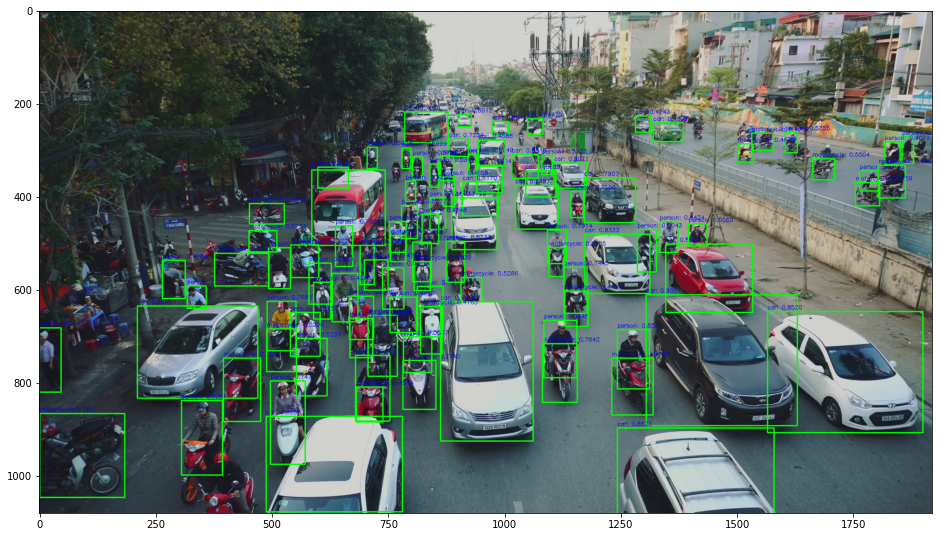

In [5]:
import cv2
import matplotlib.pyplot as plt

img_array = cv2.cvtColor(cv2.imread('/content/data/img01.png'), cv2.COLOR_BGR2RGB)

draw_img = get_detected_img(export_model, img_array, is_print=True)
plt.figure(figsize=(16, 16))
plt.imshow(draw_img)

/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py:1348: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


person: 0.9743
person: 0.9432
person: 0.9180
person: 0.8508
car: 0.7775
car: 0.7682
car: 0.7188
person: 0.7122
car: 0.7111
car: 0.6500
car: 0.6117
car: 0.5698
car: 0.5567
car: 0.5251
Detection 수행시간: 7.9 초


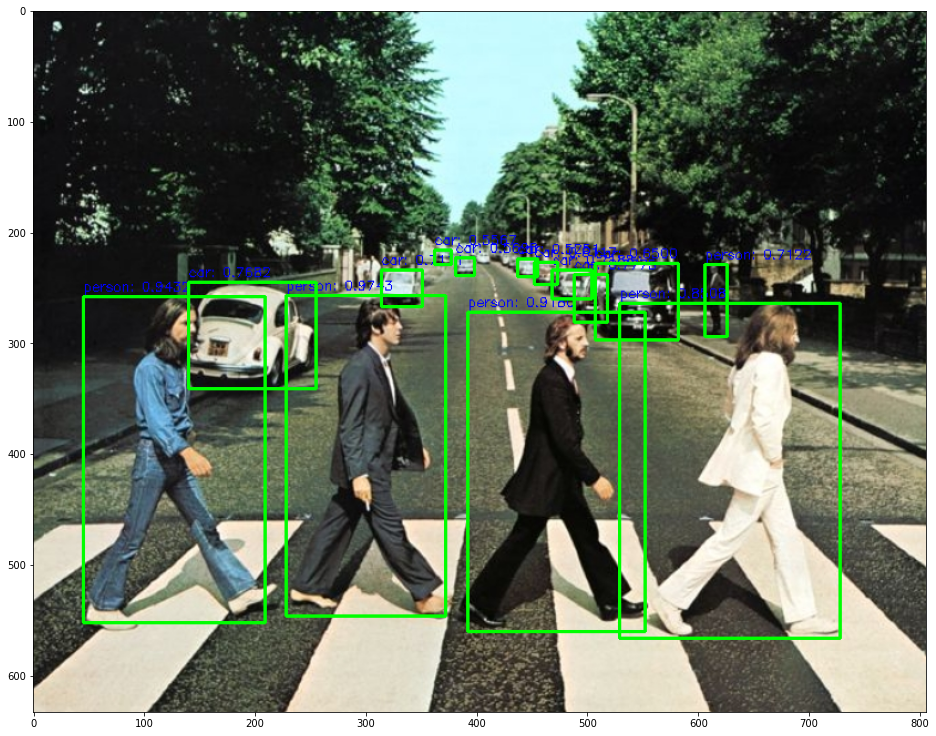

In [6]:
import cv2
import matplotlib.pyplot as plt

img_array = cv2.cvtColor(cv2.imread('/content/data/beatles01.jpg'), cv2.COLOR_BGR2RGB)

draw_img = get_detected_img(export_model, img_array, is_print=True)
plt.figure(figsize=(16, 16))
plt.imshow(draw_img)